In [1]:
%matplotlib inline
import numpy as np
from desc.equilibrium import Equilibrium
from desc.geometry import FourierRZToroidalSurface
from desc.profiles import PowerSeriesProfile
from desc.plotting import plot_1d, plot_section, plot_surfaces
import desc.io
import sys
import os

sys.path.insert(0, os.path.abspath("."))
sys.path.append(os.path.abspath("../../../"))

DESC version 0.7.2,using JAX backend, jax version=0.4.1, jaxlib version=0.4.1, dtype=float64
Using device: CPU, with 1.67 GB available memory


In [2]:
# initial input
R = [[0,0,10], [1,0,1], [1,1,0.3], [-1,-1,-0.3]]
Z = [[0,0,0], [-1,0,1], [1,-1,-0.3], [-1,1,-0.3]]
p = [[0,1.8e4], [2,-3.6e4], [4, 1.8e4]]
iota = [[0,1.0], [2,1.5]]

In [3]:
# calculate surface coefficients for p and iota
pc = [i[1] for i in p]
pm = [i[0] for i in p]
iotac = [j[1] for j in iota]
iotam = [j[0] for j in iota]

In [4]:
# calculate surface coefficients for R and Z


In [5]:
# using the example input file
surface = FourierRZToroidalSurface(
    R_lmn=[10, 1, 0.3, 0],
    modes_R=[[0, 0], [1, 0], [1, 1], [-1, -1]],  # modes given as [m,n] for each coefficient
    Z_lmn=[0, 1, -0.3, 0],
    modes_Z=[[0, 0], [-1, 0], [1, -1], [-1, 1]],
)

/Users/liangtao/opt/anaconda3/lib/python3.8/site-packages/desc/geometry/surface.py:121: UserWarning: Left handed coordinates detected, switching sign of theta. To avoid this warning in the future, switch the sign of all modes with m<0
  warnings.warn(


In [29]:
# pressure and iota profile
pressure = PowerSeriesProfile(params=pc, modes=pm)
iota = PowerSeriesProfile(params=iotac, modes=iotam)
print(pressure)
print(eq.p_l)

PowerSeriesProfile at 0x7fc594ff2190 (name=, grid=LinearGrid at 0x7fc594ff2310 (L=20, M=1, N=1, NFP=1, sym=False, node_pattern=linear), basis=PowerSeries at 0x7fc594ff2c40 (L=4, M=0, N=0, NFP=1, sym=even, spectral_indexing=linear))
[  57511.80534749   50579.58851461 -108091.3938621        0.
       0.               0.               0.               0.
       0.               0.               0.               0.
       0.        ]


In [7]:
eq = Equilibrium(
    surface=surface,
    pressure=pressure,
    iota=iota,
    Psi=1.0,  # flux (in Webers) within the last closed flux surface
    NFP=1,  # number of field periods
    L=24,  # radial spectral resolution
    M=12,  # poloidal spectral resolution
    N=4,  # toroidal spectral resolution (axisymmetric case, so we don't need any toroidal modes)
    L_grid=32,  # real space radial resolution, slightly oversampled
    M_grid=18,  # real space poloidal resolution, slightly oversampled
    N_grid=6,  # real space toroidal resolution (axisymmetric, so we don't need any grid points toroidally)
    sym=True,  # explicitly enforce stellarator symmetry
)

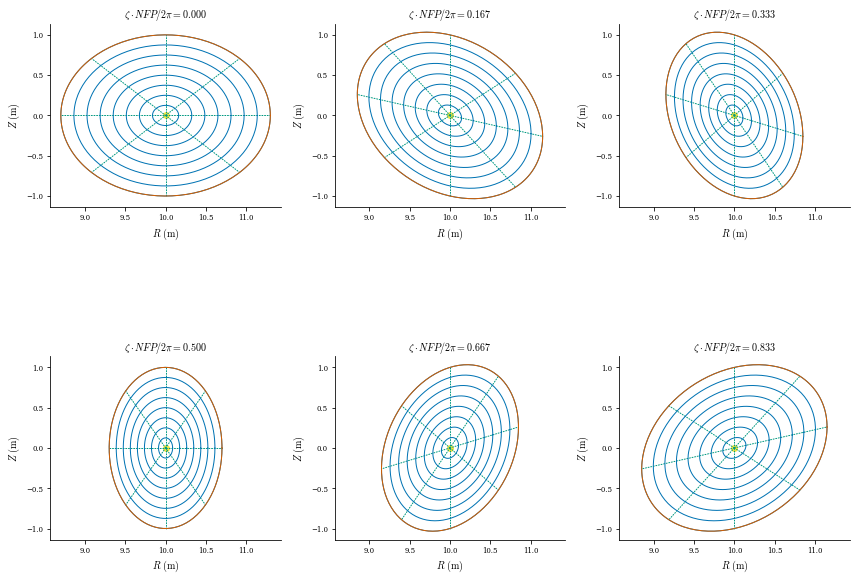

In [8]:
# plot_surfaces generates poincare plots of the flux surfaces
plot_surfaces(eq);

In [9]:
from desc.optimize import Optimizer

# create an Optimizer object using the lsq-exact optimizer
optimizer = Optimizer("lsq-exact")

In [10]:
from desc.objectives import (
    get_fixed_boundary_constraints,
    ObjectiveFunction,
    FixBoundaryR,
    FixBoundaryZ,
    FixLambdaGauge,
    FixPressure,
    FixIota,
    FixPsi,
    ForceBalance,
)

# remake the constraints and objective, since we have changed the resolution of our equilibrium
constraints = (
    FixBoundaryR(fixed_boundary=True),  # enforce fixed  LCFS for R
    FixBoundaryZ(fixed_boundary=True),  # enforce fixed  LCFS for R
    FixLambdaGauge(),  # Fix the gauge for Lambda (in stellarator symmetric cases, this sets lambda to zero at the magnetic axis)
    FixPressure(),  # enforce that the pressure profile stay fixed
    FixIota(),  # enforce that the rotational transform profile stay fixed
    FixPsi(),  # enforce that the enclosed toroidal stay fixed
)
# choose the objectives to be ForceBalance(), which is a wrapper function for RadialForceBalance() and HelicalForceBalance()
objectives = ForceBalance()
# the final ObjectiveFunction object which we can pass to the eq.solve method
obj = ObjectiveFunction(objectives=objectives)

In [11]:
# gaussian process for p
def p_mean(x, p_v):
    return p_v[0] - p_v[1]*x**2 + p_v[2]*x**4

def p_cov(x1, x2, sigma_f=5000, ell=0.1):
    return sigma_f**2 * np.exp(-0.5 * ((x1 - x2) / ell)**2)

# gaussian process for iota
def i_mean(x, i_v):
    return i_v[0] + i_v[1]*x**2

def i_cov(x1, x2, sigma_f=0.05, ell=0.1):
    return sigma_f**2 * np.exp(-0.5 * ((x1 - x2) / ell)**2)

Building objective: force
Precomputing transforms
Perturbing p_l, i_l
Factorizing linear constraints
Computing df
Factoring df
Computing d^2f
||dx||/||x|| =  7.039e-02
Perturbing p_l, i_l
Factorizing linear constraints
Computing df
Factoring df
Computing d^2f
||dx||/||x|| =  5.734e-02
Perturbing p_l, i_l
Factorizing linear constraints
Computing df
Factoring df
Computing d^2f
||dx||/||x|| =  5.622e-02
Perturbing p_l, i_l
Factorizing linear constraints
Computing df
Factoring df
Computing d^2f
||dx||/||x|| =  3.225e-02
Perturbing p_l, i_l
Factorizing linear constraints
Computing df
Factoring df
Computing d^2f
||dx||/||x|| =  3.398e-02


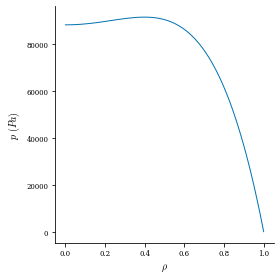

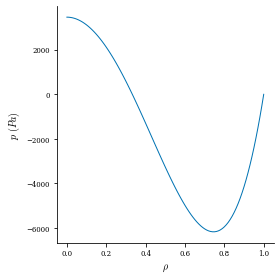

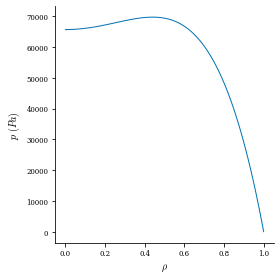

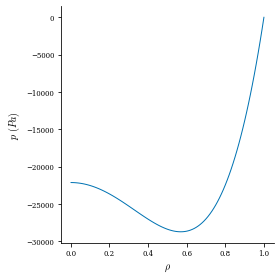

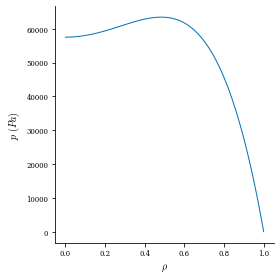

In [12]:
pv_array = []
iv_array = []
for i in range(5):
    # pressure
    px = np.linspace(-1, 1, 2)
    pmu = p_mean(px, eq.p_l)
    pK = np.zeros((len(px), len(px)))
    for i in range(len(px)):
        for j in range(len(px)):
            pK[i,j] = p_cov(px[i], px[j])
    pnew = np.random.multivariate_normal(pmu, pK)
    # get new 3 variables
    pnew = np.append(pnew, -np.sum(pnew))
    pv_array.append(pnew)
    # extend
    pextend = np.pad(pnew, (0, len(eq.p_l) - len(pnew)), 'constant')
    delta_p = pextend
    # iota
    ix = np.linspace(-1, 1, 2)
    imu = i_mean(ix, eq.i_l)
    iK = np.zeros((len(ix), len(ix)))
    for i in range(len(ix)):
        for j in range(len(ix)):
            iK[i,j] = i_cov(ix[i], ix[j])
    inew = np.random.multivariate_normal(imu, iK)
    iv_array.append(inew)
    # extend
    iextend = np.pad(inew, (0, len(eq.i_l) - len(inew)), 'constant')
    delta_i = iextend
    # set up
    cdelta = {}
    cdelta["p_l"] = eq.p_l
    cdelta['i_l'] = eq.i_l
    eqnew = eq.perturb(dp=delta_p, di=delta_i, order=2, objective=obj, constraints=constraints)
    plot_1d(eq, "p")

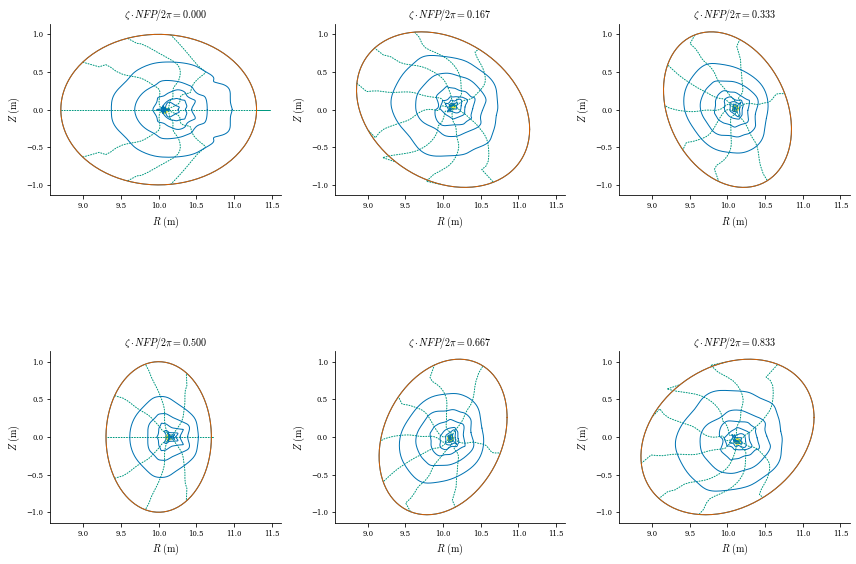

In [13]:
plot_surfaces(eqnew);

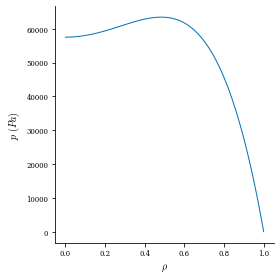

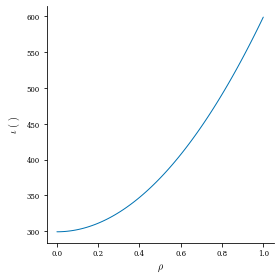

In [14]:
plot_1d(eqnew, "p");
plot_1d(eqnew, "iota");

In [15]:
print(eqnew.p_l)
print(eqnew.i_l)

[  57511.80534749   50579.58851461 -108091.3938621        0.
       0.               0.               0.               0.
       0.               0.               0.               0.
       0.        ]
[299.23243852 299.56516637   0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.        ]


In [16]:
print(dir(eq))

['L', 'L_basis', 'L_grid', 'L_lmn', 'M', 'M_grid', 'N', 'NFP', 'N_grid', 'Psi', 'R_basis', 'R_lmn', 'Ra_n', 'Rb_lmn', 'Z_basis', 'Z_lmn', 'Za_n', 'Zb_lmn', '_L', '_L_basis', '_L_grid', '_L_lmn', '_M', '_M_grid', '_N', '_NFP', '_N_grid', '_Psi', '_R_basis', '_R_lmn', '_R_sym', '_Z_basis', '_Z_lmn', '_Z_sym', '__abstractmethods__', '__class__', '__copy__', '__deepcopy__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__slots__', '__str__', '__subclasshook__', '__weakref__', '_abc_impl', '_axis', '_bdry_mode', '_current', '_io_attrs_', '_iota', '_node_pattern', '_optimize', '_pressure', '_set_up', '_solved', '_spectral_indexing', '_surface', '_sym', 'axis', 'bdry_mode', 'c_l', 'change_resolution', 'compute', 'compute_flux

In [21]:
print(eq.Rb_lmn)
# 47, 48, 49, 62
def my_function(theta, phi):
    return 10 + np.cos(theta) + 0.3*np.cos(theta+19*phi)

# Define the mean function for the Gaussian process
def mean(theta, phi):
    return 10 + np.cos(theta) + 0.3*np.cos(theta+19*phi)

# Define the covariance function for the Gaussian process
def cov(x1, x2, sigma_f=1.0, ell=1.0):
    return sigma_f**2 * np.exp(-0.5 * ((x1 - x2)**2) / (ell**2))

# Generate a grid of input values
x1 = np.linspace(0, 2*np.pi, 3)
x2 = np.linspace(0, 2*np.pi, 3)
X1, X2 = np.meshgrid(x1, x2)
X = np.vstack([X1.ravel(), X2.ravel()]).T

# Compute the mean and covariance matrices
mu = mean(x1,x2)
print(mu)
K = np.zeros((len(x1), len(x1)))
for i in range(len(x1)):
    for j in range(len(x1)):
        K[i,j] = cov(np.linalg.norm(X[i]), np.linalg.norm(X[j]))

# Sample from the Gaussian process
Rbf = np.random.multivariate_normal(mu, K)
print(Rbf)

[ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.  -0.  10.   1.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.3  0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0. ]
[11.3  9.3 11.3]
[11.79081251 10.77008812 12.4554244 ]


In [22]:
print(eq.Zb_lmn)
# 40, 63
def my_function(theta, phi):
    return np.sin(theta) - 0.3*np.sin(theta+19*phi)

# Define the mean function for the Gaussian process
def mean(theta, phi):
    return np.sin(theta) - 0.3*np.sin(theta+19*phi)

# Define the covariance function for the Gaussian process
def cov(x1, x2, sigma_f=1.0, ell=1.0):
    return sigma_f**2 * np.exp(-0.5 * ((x1 - x2)**2) / (ell**2))

# Generate a grid of input values
x1 = np.linspace(0, 2*np.pi, 2)
x2 = np.linspace(0, 2*np.pi, 2)
X1, X2 = np.meshgrid(x1, x2)
X = np.vstack([X1.ravel(), X2.ravel()]).T

# Compute the mean and covariance matrices
mu = mean(x1,x2)
K = np.zeros((len(x1), len(x1)))
for i in range(len(x1)):
    for j in range(len(x1)):
        K[i,j] = cov(np.linalg.norm(X[i]), np.linalg.norm(X[j]))

# Sample from the Gaussian process
Zbf = np.random.multivariate_normal(mu, K)
print(Zbf)

[ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  -0.3  0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.  -1.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.  -0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
[ 0.55574538 -0.30349269]


In [23]:
# actual array for Zb
Zbnew = np.zeros(len(eq.Zb_lmn))
Zbnew[40] = Zbf[0]
Zbnew[63] = Zbf[1]
print(Zbnew)

[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.55574538  0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.         -0.30349269  0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.         

In [24]:
# actual array for Rb
print(len(eq.Rb_lmn))
Rbnew = np.zeros(len(eq.Rb_lmn))
Rbnew[48] = Rbf[0]
Rbnew[49] = Rbf[1]
Rbnew[62] = Rbf[2]
print(Rbnew)

113
[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
 11.79081251 10.77008812  0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.         12.4554244   0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.     

In [25]:
eq2 = eqnew.perturb(dRb=Rbnew, order=2)

Building objective: force
Precomputing transforms
Perturbing Rb_lmn
Factorizing linear constraints
Computing df
Factoring df
Computing d^2f
||dx||/||x|| =  1.029e-01


In [26]:
eq2 = eqnew.perturb(dZb=Zbnew, order=2)

Building objective: force
Precomputing transforms
Perturbing Zb_lmn
Factorizing linear constraints
Computing df
Factoring df
Computing d^2f
||dx||/||x|| =  1.911e-02


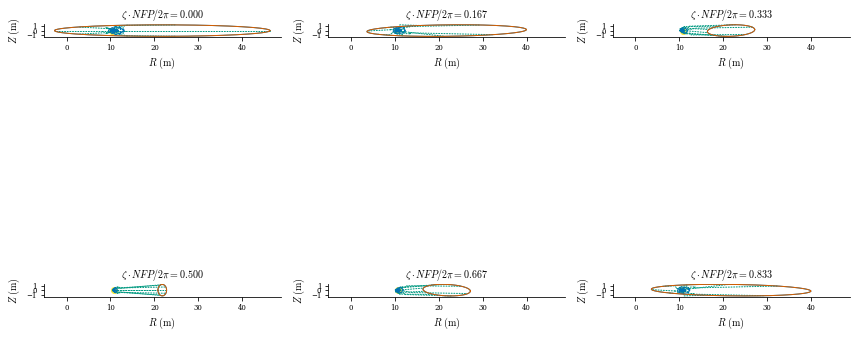

In [27]:
plot_surfaces(eq2);

In [16]:
# gaussian process for p
def mean(x):
    return 18000 - 36000*x**2 + 18000*x**4

def cov(x1, x2, sigma_f=5000, ell=0.1):
    return sigma_f**2 * np.exp(-0.5 * ((x1 - x2) / ell)**2)

x = np.linspace(-1, 1, 2)

mu = mean(x)
K = np.zeros((len(x), len(x)))
for i in range(len(x)):
    for j in range(len(x)):
        K[i,j] = cov(x[i], x[j])

p2 = np.random.multivariate_normal(mu, K)
p2 = np.append(p2, -np.sum(p2))
print(p2)

[ 6645.80661068 -5753.44804445  -892.35856622]


In [17]:
print(p2[1])

-5753.448044450601


In [14]:
# gaussian process for iota
def mean(x):
    return 1 + 1.5*x**2

def cov(x1, x2, sigma_f=0.05, ell=0.1):
    return sigma_f**2 * np.exp(-0.5 * ((x1 - x2) / ell)**2)

x = np.linspace(-1, 1, 2)

mu = mean(x)
K = np.zeros((len(x), len(x)))
for i in range(len(x)):
    for j in range(len(x)):
        K[i,j] = cov(x[i], x[j])

i2 = np.random.multivariate_normal(mu, K)
print(i2)

[2.46653604 2.51648854]


In [15]:
#update pressure profile
#p2 = [1, -2, 1] * p2
#print(p2)
newp2 = np.pad(p2, (0, len(eq.p_l) - len(p2)), 'constant')
delta_p = newp2
print(delta_p)

[-4706.03921587  4549.17995924   156.85925663     0.
     0.             0.             0.             0.
     0.             0.             0.             0.
     0.        ]


In [16]:
#update iota profile
newi2 = np.pad(i2, (0, len(eq.i_l) - len(i2)), 'constant')
delta_i = newi2
print(delta_i)

[2.46653604 2.51648854 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ]


In [17]:
#eq.p_l = delta_p
#eq.i_l = delta_i
# update delta
cdelta = {}
cdelta["p_l"] = eq.p_l
cdelta['i_l'] = eq.i_l
#cdelta['Rb_lmn'] = eq.Rb_lmn
#cdelta['Zb_lmn'] = eq.Zb_lmn

In [18]:
eq1 = eq.perturb(dp=delta_p, di=delta_i, order=2, objective=obj, constraints=constraints)

Building objective: force
Precomputing transforms
Perturbing p_l, i_l
Factorizing linear constraints
Computing df
Factoring df
Computing d^2f
||dx||/||x|| =  4.667e-02


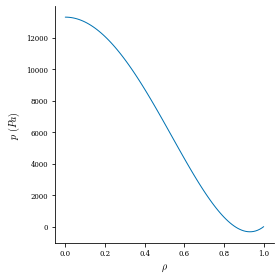

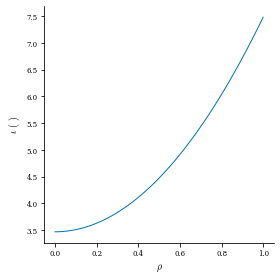

In [19]:
plot_1d(eq1, "p");
plot_1d(eq1, "iota");

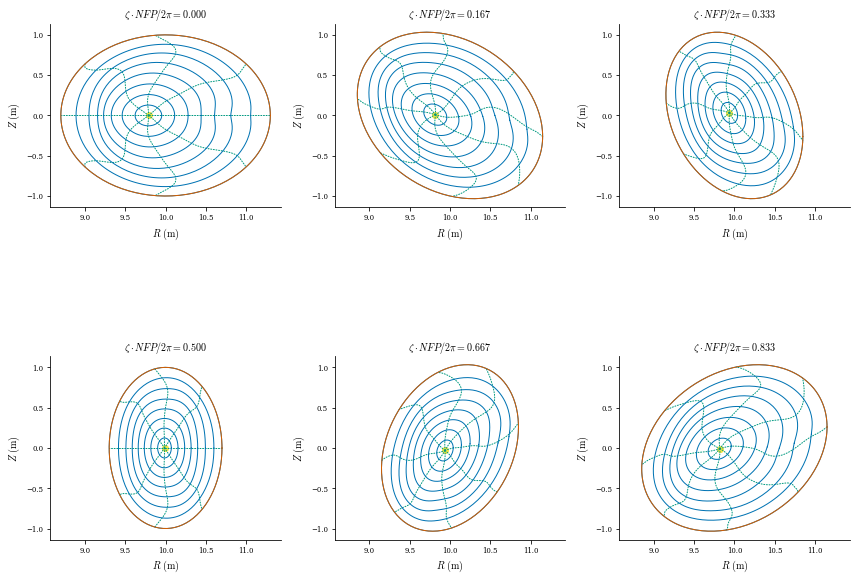

In [20]:
plot_surfaces(eq1);

In [21]:
print(eq.p_l)
print(eq.i_l)

[ 13293.96078413 -31450.82004076  18156.85925663      0.
      0.              0.              0.              0.
      0.              0.              0.              0.
      0.        ]
[3.46653604 4.01648854 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ]


In [22]:
# gaussian process for p
def mean(x):
    return eq.p_l[0] - eq.p_l[1]*x**2 + eq.p_l[2]*x**4

def cov(x1, x2, sigma_f=5000, ell=0.1):
    return sigma_f**2 * np.exp(-0.5 * ((x1 - x2) / ell)**2)

x = np.linspace(-1, 1, 2)

mu = mean(x)
K = np.zeros((len(x), len(x)))
for i in range(len(x)):
    for j in range(len(x)):
        K[i,j] = cov(x[i], x[j])

p2 = np.random.multivariate_normal(mu, K)
p2 = np.append(p2, -np.sum(p2))
print(p2)

[  69197.41147015   71019.4900394  -140216.90150956]


In [23]:
# gaussian process for iota
def mean(x):
    return eq.i_l[0] + eq.i_l[1]*x**2

def cov(x1, x2, sigma_f=0.05, ell=0.1):
    return sigma_f**2 * np.exp(-0.5 * ((x1 - x2) / ell)**2)

x = np.linspace(-1, 1, 2)

mu = mean(x)
K = np.zeros((len(x), len(x)))
for i in range(len(x)):
    for j in range(len(x)):
        K[i,j] = cov(x[i], x[j])

i2 = np.random.multivariate_normal(mu, K)
print(i2)

[7.53086411 7.56075079]


In [24]:
newp2 = np.pad(p2, (0, len(eq.p_l) - len(p2)), 'constant')
delta_p = newp2
print(delta_p)
newi2 = np.pad(i2, (0, len(eq.i_l) - len(i2)), 'constant')
delta_i = newi2
print(delta_i)

[  69197.41147015   71019.4900394  -140216.90150956       0.
       0.               0.               0.               0.
       0.               0.               0.               0.
       0.        ]
[7.53086411 7.56075079 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ]


In [25]:
cdelta = {}
cdelta["p_l"] = eq.p_l
cdelta['i_l'] = eq.i_l

In [26]:
eq1 = eq.perturb(dp=delta_p, di=delta_i, order=2, objective=obj, constraints=constraints)

Perturbing p_l, i_l
Factorizing linear constraints
Computing df
Factoring df
Computing d^2f
||dx||/||x|| =  5.202e-02


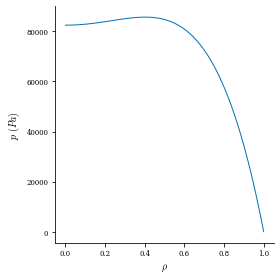

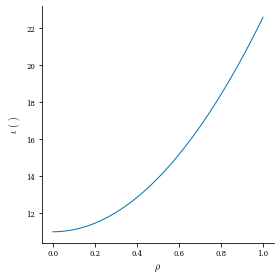

In [27]:
plot_1d(eq1, "p");
plot_1d(eq1, "iota");

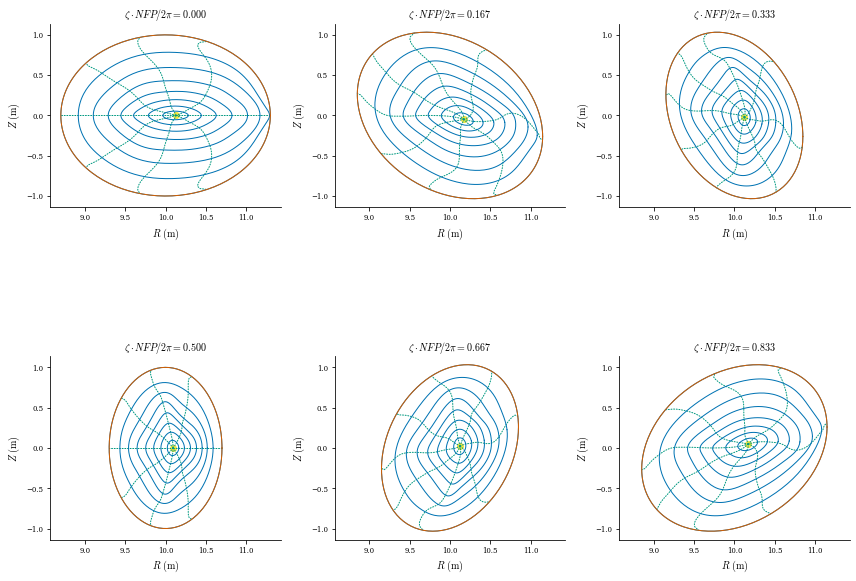

In [28]:
plot_surfaces(eq1);